In [1]:
import numpy as np
import os
import xarray as xr
import cfgrib
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from pathlib import Path

from hrrr_lib import config_file
from hrrr_lib.base_file import BaseFile
from hrrr_lib.grib_file import GribFile

In [ ]:
def find_index_of_nearest_xy(y_array, x_array, y_point, x_point):
    distance = (y_array-y_point)**2 + (x_array-x_point)**2
    idy,idx = numpy.where(distance==distance.min())
    return idy[0],idx[0]

In [28]:
def read_irwin():
        # TZ in MDT. 
    df = pd.read_csv('/Users/u1321700/ipynb/SW_compare/Irwin_raw/Irwin_WY20.csv',
                 skiprows=[0,1,2,3,4,5,7],
                 na_values=['NAN','NA','N/A','NaN']
                    )
    dfr = df.iloc[:,15:20]
    dfr['Timestamp'] = pd.to_datetime(dfr['Unnamed: 15'])
    dfr.index = dfr['Timestamp']
        # set time zone then convert to UTC and drop tz identifier
    dfr = dfr.tz_localize(tz='Etc/GMT-7')
    dfr = dfr.tz_convert(None)
    dfr = dfr.loc[:'20200702']
    return dfr

dfr = read_irwin()

In [29]:
dfr['net_solar_ir'] = dfr['Incoming) Solar_Wm2_1_Avg'] - dfr['Outgoing_Solar_Wm2_3_Avg']

In [ ]:
# Irwin coords: 38.88723, -107.10841
# modulo to convert from 180 degree longitude system to 360
-107.10841 % 360

In [ ]:
out = GribFile().load(file='/Users/u1321700/data/hrrr_all/HRRR_CBR_wy20/hrrr201910/hrrr.20191001/hrrr.t00z.wrfsfcf01.grib2',
          var_map=GribFile().VAR_MAP)
ds = out[5]; ds

In [ ]:
# Irwin coords
find_index_of_nearest_xy(ds.latitude, ds.longitude, 38.88723, 252.89159)

In [ ]:
# 3km grid to m, from GribFile
x, y = 127 * 3000, 168 * 3000; x, y

In [ ]:
ds.time.values[0]

In [ ]:
ds = ds.short_wave.where((ds.x==381000) & (ds.y==504000), drop=True); ds

In [ ]:
directory = Path('/Users/u1321700/data/hrrr_all/')
files = sorted(directory.rglob('*00.grib2'))

timestamps = []
vals = []
    
for f in files:
    print(f)
    ds = GribFile().load(file=f,
            var_map=GribFile().VAR_MAP)
    ds = ds[5]
    ds = ds.short_wave.where((ds.x==504000) & (ds.y==381000), drop=True)
    timestamps.append(ds.time.values[0])
    vals.append(ds[0,0].values[0])

In [8]:
df_hrrr = pd.DataFrame (vals, columns=['dswrf'])
df_hrrr['timestamp'] = pd.DataFrame(timestamps)

df_hrrr.index = pd.to_datetime(df_hrrr['timestamp'])
df_hrrr.sort_index(inplace=True)
#df_hrrr.to_csv('ir_dwsrf_20200310.csv')

In [60]:
df_hrrr = pd.read_csv('/Users/u1321700/ipynb/HRRR/ir_dwsrf_20200310.csv')
df_hrrr.index = pd.to_datetime(df_hrrr['timestamp'])
df_hrrr.sort_index(inplace=True)
df_hrrr = df_hrrr[['0']]
df_hrrr.rename(columns={'0':'dwsrf_hrrr'}, inplace=True)

In [61]:
df_n = df_hrrr.join(dfr, how='outer')

<AxesSubplot:>

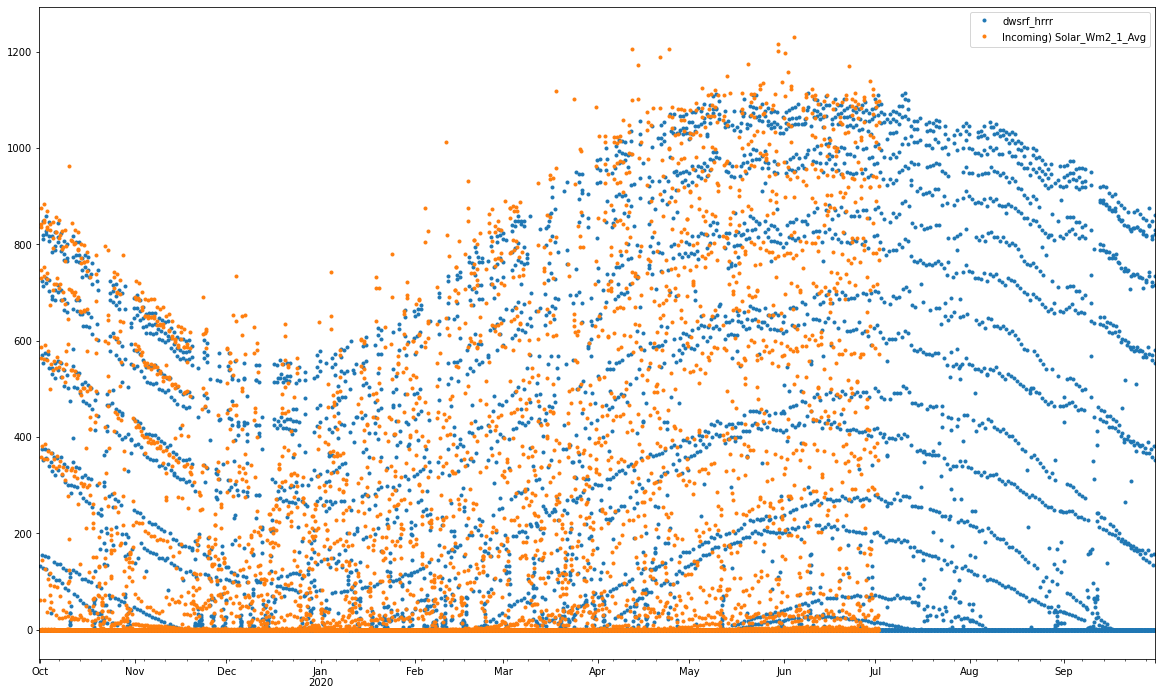

In [62]:
df_n[['dwsrf_hrrr','Incoming) Solar_Wm2_1_Avg']].plot(figsize=(20,12), style=".")

Comparison of incoming solar from HRRR and Irwin Study Plot